In [2]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [3]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [4]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [5]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [15]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [7]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [8]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))


In [9]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)


In [10]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal


In [11]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [12]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [13]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()


In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER  = band_energy_ratio(spec, split_frequency, sr)
        #BER /= np.max(BER)
        #feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)



**Zero crossing rate**

- Media. 512 de frame, cuton en 1000 cutoff en 5000. La media separa bastante las peras de las manzanas, las peras quedan arriba y las manzanas abajo, en el medio quedan las naranjas y las bananas solapadas pero no tanto.

In [45]:
def preemphasis(signal, coef=0.97):
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

- Hice la prueba con el preenfásis antes y después del filtro pasa banda con un coeficiente de 0.97 como viene por defecto pero lo bastardea demasiado y difumina la separación.
- En cambio la utilización del filtro pasabanda en esa banda estrecha hace mucho por la dispersión de las mediciones de zcr en cada uno de los audios. Cuando se pone el filtro, los audios quedan mas juntos dentro de cada grupo respecto del zcr

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


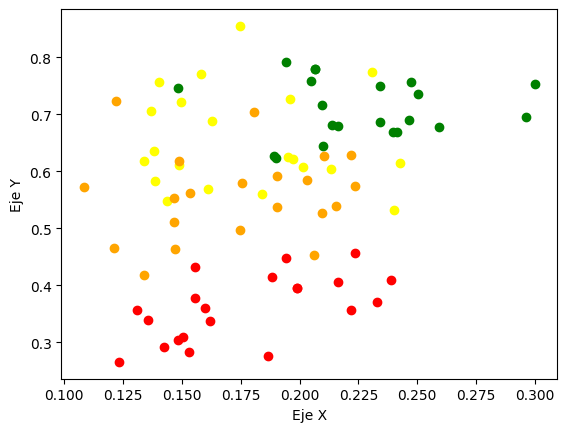

In [53]:
cutoff = 5000
cuton = 1000
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.mean(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- RMS

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


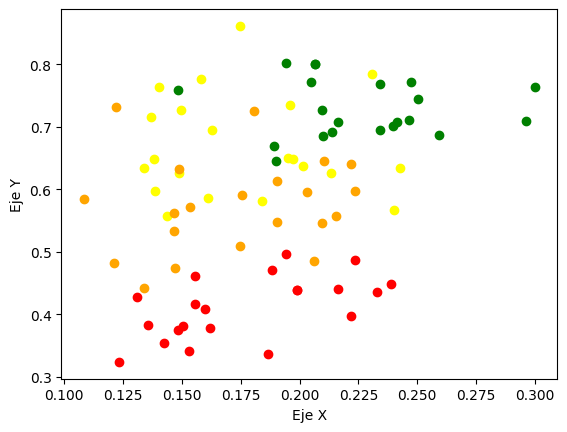

In [83]:
cutoff = 5000
cuton = 1000
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.sqrt(np.mean(zcr**2))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- El RMS y la Media andan bien en la banda estrecha entre 1000 y 5000, pero el resto de las medidas que vienen a continuación tienen mejores resultados cuando se miden en una banda mas ancha. Ahora lo estoy tomando entre 10 y 10000 las siguientes

- Máximo. Fuaaaaa culiadooo. El ZCR separa joya las manzanas de las demas frutas. El máximo del zero crossing obviamente. Me gusta un poco mas sin filtro con el FRAME_SIZE a 2048 que en 512. Es mas, me gusta mas en 1024 que en 2048

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


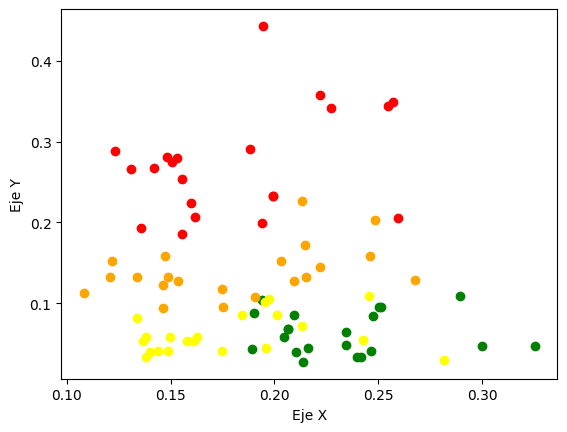

In [80]:
cutoff = 10000
cuton = 10
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.max(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.max(np.abs(zcr))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- Con el mínimo

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


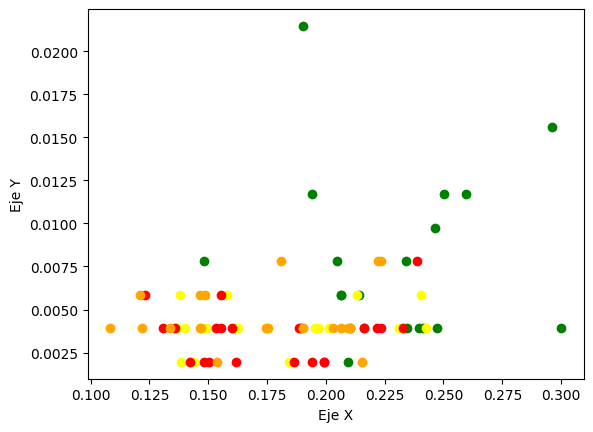

In [76]:
cutoff = 10000
cuton = 10
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.min(np.abs(zcr))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la varianza. La varianza permite muy bien la separación de las manzanas

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


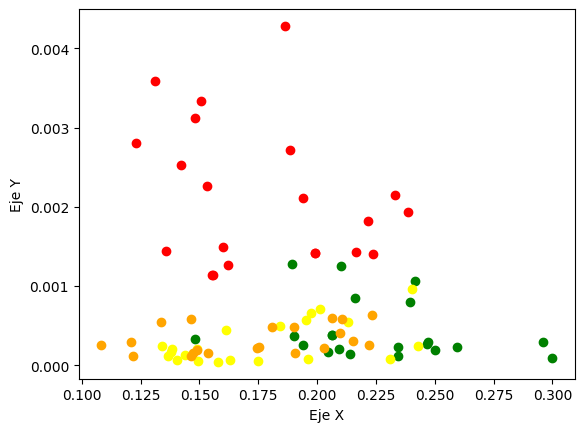

In [63]:
cutoff = 5000
cuton = 1000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.var(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la desviación estándar. Nuevamente, se nota bastante la separación de las manzanas, pero las naranjas igual se ven en un cluster medio superpuesto con las bananas y separadas de las peras. un frame de 512 con frecuencias de corte de 20 y 10000 de una

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


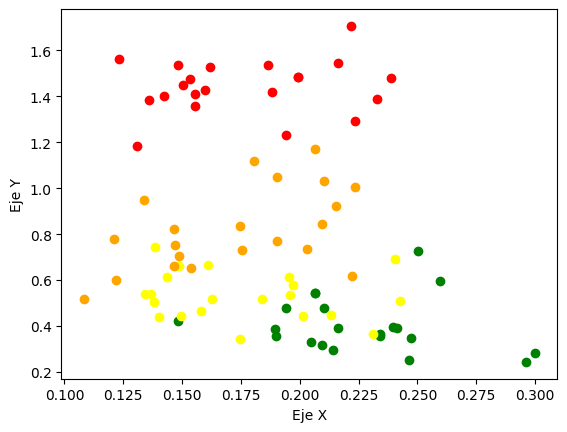

In [75]:
cutoff = 10000
cuton  = 20
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.std(zcr)/np.mean(np.abs(zcr))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momento sin la suma

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


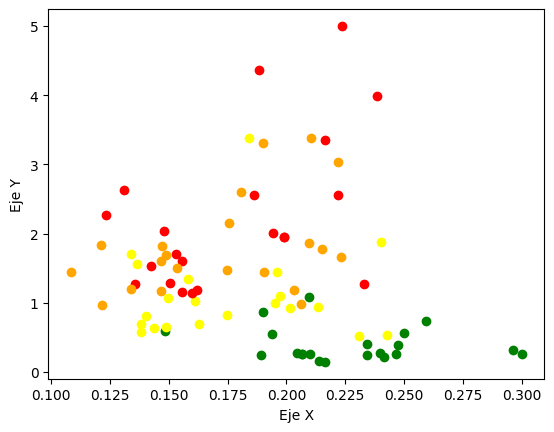

In [84]:
cutoff = 10000
cuton = 10
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        frames = range(len(zcr))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
        feat = np.dot(np.abs(zcr), t)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la suma. Funciona separando bien las peras de lo demas aumentando la banda de corte bajo. probe con 1000 y 10000 y anda bien.

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


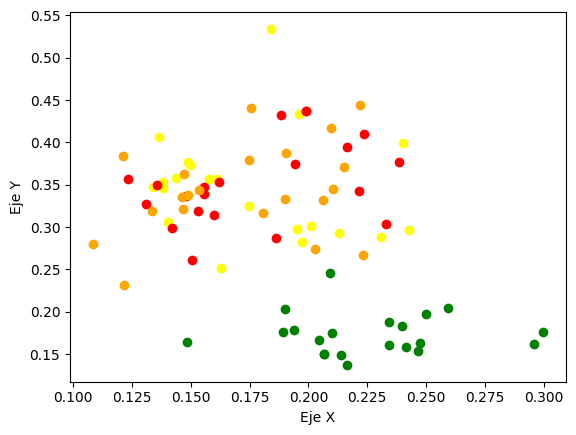

In [95]:
cutoff = 10000
cuton = 900
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        frames = range(len(zcr))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
        feat = np.dot(np.abs(zcr), t)/np.sum(np.abs(zcr))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la banda de paso estrecha, con los frames de 512, con la media en los 2/7 se la banca bastante piola. Las manzanas de las peras se separan una enormidad. Cuando se usa una banda mas ancha hay mucha mas dispersión de las mediciones de la media en los tramos de los audios de un mismo grupo, pero es verdad que se logra una separación aún mayor de las mediciones entre las peras y las manzanas. Tal vez, en banda ancha lo que conviene es hacer la medición de las desviaciones lo que separaría mucho las peras de las manzanas

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


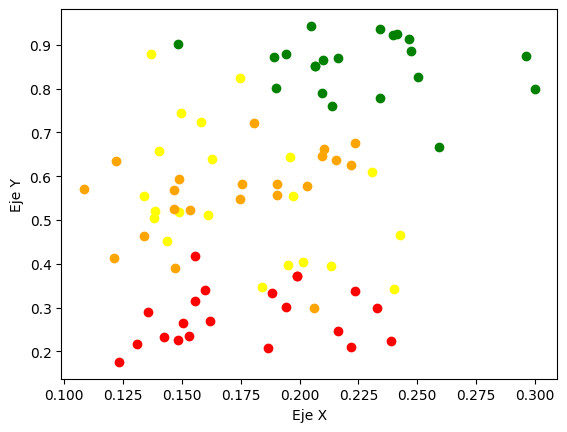

In [105]:
cutoff = 5000
cuton = 1000
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.mean(zcr[((len(zcr)*3)//14 - 5) : ((len(zcr)*3)//14 + 5)])
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
        
# Ploteo
plot_features2d(features)

el máximo del zcr a los 2/3 separa las naranjas. Con el máximo a los 4/5 se separan las naranjas de lo demas. O a los 3/4 también. A los 3/4 entre 10 10000 con frames de 512 con 10 para cada lado separa joyamente a las naranjas de los demas quedando siempre por encima las naranjas con medidas bastante variables entre sí.

C:\Users\Juan\AppData\Local\Temp\ipykernel_6356\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


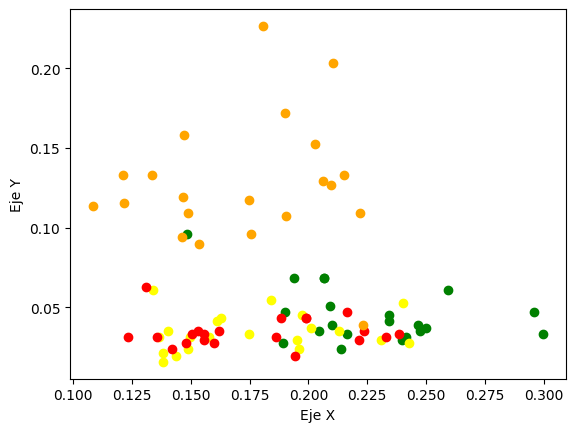

In [129]:
cutoff = 10000
cuton = 10
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.max(zcr[((len(zcr)*3)//4 - 10) : ((len(zcr)*3)//4 + 10)])
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)
